In [1]:
from commonfunctions import  *

In [2]:
def img2gray(image: np.ndarray) -> np.ndarray:
    if len(image.shape) > 3:
        image = image[:, :, 0:3, 0]
    if len(image.shape) == 2:
        return image
    else:
        gray_img = rgb2gray(image)
        return gray_img

In [3]:
def noiseRemoval(img: np.ndarray) -> np.ndarray:
    #clean_img = median(img, selem=disk(3))
    clean_img = gaussian(img, 1.2)
    return clean_img

In [4]:
def median_filter(img,w=10,h=10):
    edgex = int(w/2)
    edgey = int(h/2)
    new_img = np.zeros(img.shape)
    for i in range(edgex,img.shape[0]-edgex):
        for j in range(edgey,img.shape[1]-edgey):
            new_img[i][j] = np.median(img[i-edgex:i+edgex+1,j-edgey:j+edgey+1])
    return new_img

In [5]:
def contrastEnhancemet(img: np.ndarray) -> None:
        enhanced = img.copy()
        low, high = np.percentile(img, [0.2, 99.8])
        enhanced = rescale_intensity(img, in_range=(low, high))
        return enhanced

In [6]:
def local_thresholding_segment(image: np.ndarray, block_size: int, offset: float) -> None:
    image = image * 255
    binary_image = np.zeros(image.shape, dtype=bool)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            start_row = max(0, i - block_size // 2)
            end_row = min(image.shape[0], i + block_size // 2 + 1)
            start_col = max(0, j - block_size // 2)
            end_col = min(image.shape[1], j + block_size // 2 + 1)

            local_mean = np.mean(image[start_row:end_row, start_col:end_col])

            local_threshold = local_mean - offset

            binary_image[i, j] = image[i, j] < local_threshold

    return binary_image


def local_thresholding(image: np.ndarray, block_size: int, offset: float, sections_list: list[np.ndarray], index) -> None:
    segmented_image = local_thresholding_segment(image, block_size, offset)
    
    sections_list[index] = segmented_image

def local_thresholding_parallelized(image: np.ndarray, block_size: int, offset: float) -> None:
    r, c = image.shape
    image_sections = [image[0:r//2, 0:c//2],  image[0:r//2, c//2:c], image[r//2:r, 0:c//2], image[r//2:r, c//2:c]]
    
    threads = list()
    sections_list = [0] * len(image_sections) 
    for i in range(len(image_sections)):
        thread = threading.Thread(target=local_thresholding, args=(image_sections[i], block_size, offset, sections_list, i, ))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()
    
    
    image[0:r//2, 0:c//2] = sections_list[0]
    image[0:r//2, c//2:c] = sections_list[1]
    image[r//2:r, 0:c//2] = sections_list[2]
    image[r//2:r, c//2:c] = sections_list[3]
    return image


    


In [7]:
# def local_thresholding(image, block_size, offset):

#     # Initialize an array to store the binary image
#     binary_image = np.zeros(image.shape, dtype=bool)

#     # Iterate over the image pixels
#     for i in range(image.shape[0]):
#         for j in range(image.shape[1]):
#             # Define the pixel neighborhood
#             start_row = max(0, i - block_size // 2)
#             end_row = min(image.shape[0], i + block_size // 2 + 1)
#             start_col = max(0, j - block_size // 2)
#             end_col = min(image.shape[1], j + block_size // 2 + 1)

#             # Compute the local mean of the neighborhood
#             local_mean = np.mean(image[start_row:end_row, start_col:end_col])

#             # Compute the local threshold
#             local_threshold = local_mean - offset

#             # Set the pixel value in the binary image based on the local threshold
#             binary_image[i, j] = image[i, j] < local_threshold

#     return binary_image

def binarize(img: np.ndarray) -> None:
    block_size = 25
    local_thresh = local_thresholding_parallelized(img, block_size, 10)
    binarized_img = (img < local_thresh).astype(np.uint8)
    return binarized_img

In [8]:
def skewCorrection(img: np.ndarray) -> np.ndarray:
    skew_corrected_imgs = transform.resize(img, (128, 256), mode='reflect', anti_aliasing=True)
    return skew_corrected_imgs

In [9]:
def preprocess(img: np.ndarray) -> np.ndarray:
    gray_img = img2gray(img)
    clean_img = noiseRemoval(gray_img)
    enhanced_img = contrastEnhancemet(clean_img)
    binarized_img = binarize(enhanced_img)
    show_images([binarized_img])
    skew_corrected_img = skewCorrection(opening(binarized_img,rectangle(5,5)))
    skeletonized_img = skeletonize(skew_corrected_img)
    return skeletonized_img

In [10]:
def readDataset(dir: str) -> list[np.ndarray]:
    dataset = []
    read_imgs = os.listdir(dir)
    for i in range(len(read_imgs)):
        image = io.imread(dir + read_imgs[i]).astype(np.uint8)
        dataset.append(preprocess(image))
    return dataset

In [11]:
def HOGFeatureExtractionSkimage(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.uint8)
    features = hog(image, orientations=9, pixels_per_cell=(9, 9),
    cells_per_block=(3,3), transform_sqrt=True, block_norm="L1")
    return features

def extractFeatures(imgs: list[np.ndarray]) -> list[np.ndarray]:
    extracted_features = []
    for i in range(len(imgs)):
        extracted_features.append(HOGFeatureExtractionSkimage(imgs[i]))
    return extracted_features


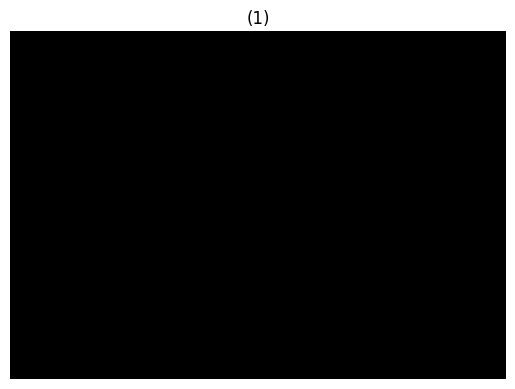

In [12]:
real_imgs = readDataset('all/real/')
forged_imgs = readDataset('all/forged/')
test_imgs = readDataset('testImgs/')

In [ ]:
real_extracted_features = extractFeatures(real_imgs)
forged_extracted_features = extractFeatures(forged_imgs)
test_extraced_features = extractFeatures(test_imgs)

In [ ]:
HOG_features = forged_extracted_features + real_extracted_features
HOG_labels_forged = [0 for _ in range(len(forged_extracted_features))]
HOG_labels_real = [1 for _ in range(len(real_extracted_features))]
HOG_labels = HOG_labels_forged + HOG_labels_real
test_imgs_label = 1

x_train, x_test, y_train, y_test = train_test_split(HOG_features, HOG_labels, test_size = 0.2, random_state = 42)
model = svm.SVC(kernel='linear')
model.fit(x_train, y_train)

accuracy = model.score(x_test, y_test)
print("SVM using HOG as feature descriptor.", 'accuracy:', accuracy * 100, '%')
accuracy = model.score(x_train, y_train)
print("SVM using HOG as feature descriptor.", 'accuracy:', accuracy * 100, '%')

dump(model, 'model.pkl')

In [ ]:

test_prediction = model.predict(test_extraced_features)
print(test_prediction)
if test_prediction == test_imgs_label:
    print("correct prediction")
else:
    print("false prediction")